<a href="https://colab.research.google.com/github/manasavadavalli/FMML-LAB/blob/main/Copy_of_FMML_M1L3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Augmentation

FMML Module 1, Lab 3

In this lab, we will see how augmentation of data samples help in improving the machine learning performance. Augmentation is the process of creating new data samples by making reasonable modifications to the original data samples. This is particularly useful when the size of the training data is small. We will use the MNISt dataset for this lab. We will also reuse functions from the previous labs.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.utils.extmath import cartesian
from skimage.transform import rotate, AffineTransform, warp

rng = np.random.default_rng(seed=42)

In [ ]:
# loading the dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()

# normalizing the data
train_X = train_X / 255
test_X = test_X / 255

# subsample from images and labels. Otherwise it will take too long!
train_X = train_X[::1200, :, :].copy()
train_y = train_y[::1200].copy()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Let us borrow a few functions from the previous labs:

In [ ]:
def NN1(traindata, trainlabel, query):
    """
    This function takes in the training data, training labels and a query point
    and returns the predicted label for the query point using the nearest neighbour algorithm

    traindata: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    trainlabel: numpy array of shape (n,) where n is the number of samples
    query: numpy array of shape (d,) where d is the number of features

    returns: the predicted label for the query point which is the label of the training data which is closest to the query point
    """
    diff = (
        traindata - query
    )  # find the difference between features. Numpy automatically takes care of the size here
    sq = diff * diff  # square the differences
    dist = sq.sum(1)  # add up the squares
    label = trainlabel[np.argmin(dist)]
    return label


def NN(traindata, trainlabel, testdata):
    """
    This function takes in the training data, training labels and test data
    and returns the predicted labels for the test data using the nearest neighbour algorithm

    traindata: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    trainlabel: numpy array of shape (n,) where n is the number of samples
    testdata: numpy array of shape (m,d) where m is the number of test samples and d is the number of features

    returns: the predicted labels for the test data which is the label of the training data which is closest to each test point
    """
    traindata = traindata.reshape(-1, 28*28)
    testdata = testdata.reshape(-1, 28*28)
    predlabel = np.array([NN1(traindata, trainlabel, i) for i in testdata])
    return predlabel


def Accuracy(gtlabel, predlabel):
    """
    This function takes in the ground-truth labels and predicted labels
    and returns the accuracy of the classifier

    gtlabel: numpy array of shape (n,) where n is the number of samples
    predlabel: numpy array of shape (n,) where n is the number of samples

    returns: the accuracy of the classifier which is the number of correct predictions divided by the total number of predictions
    """
    assert len(gtlabel) == len(
        predlabel
    ), "Length of the ground-truth labels and predicted labels should be the same"
    correct = (
        gtlabel == predlabel
    ).sum()  # count the number of times the groundtruth label is equal to the predicted label.
    return correct / len(gtlabel)

In this lab, we will use the image pixels themselves as features, instead of extracting features. Each image has 28*28 pixels, so we will flatten them to 784 pixels to use as features. Note that this is very compute intensive and will take a long time. Let us first check the baseline accuracy on the test set without any augmentations. We hope that adding augmentations will help us to get better results.

In [ ]:
testpred = NN(train_X, train_y, test_X)
print("Baseline accuracy without augmentation:",
      Accuracy(test_y, testpred)*100, "%")

Baseline accuracy without augmentation: 64.72 %


Let us try to improve this accuracy using augmentations. When we create augmentations, we have to make sure that the changes reflect what will naturally occur in the dataset. For example, we should not add colour to our samples as an augmentation because they do not naturally occur. We should not also flip the images in MNIST, because flipped images have different meanings for digits. So, we will use the following augmentations:

### Augmentation 1: Rotation

Let us try rotating the image a little. We will use the `rotate` function from the `skimage` module. We will rotate the image by 10 degrees and -10 degrees. Rotation is a reasonable augmentation because the digit will still be recognizable even after rotation and is representative of the dataset.

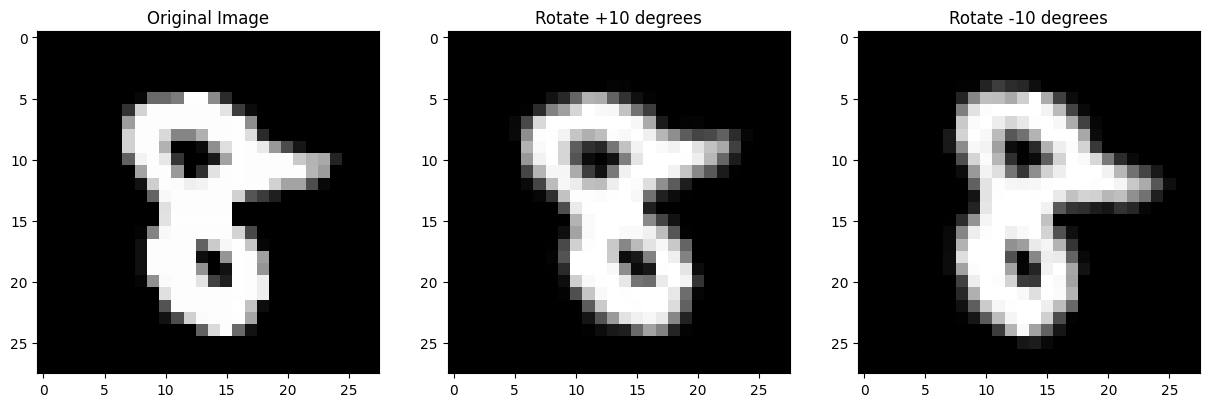

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(train_X[2], cmap="gray")
axs[0].set_title("Original Image")

axs[1].imshow(rotate(train_X[2], 10), cmap="gray")
axs[1].set_title("Rotate +10 degrees")

axs[2].imshow(rotate(train_X[2], -10), cmap="gray")
axs[2].set_title("Rotate -10 degrees")

plt.show()

After rotating, the the class of the image is still the same. Let us make a function to rotate multiple images by random angles. We want a slightly different image every time we run this function. So, we generate a random number between 0 and 1 and change it so that it lies between -constraint/2 and +constraint/2

In [ ]:
def augRotate(sample, angleconstraint):
    """
    This function takes in a sample and an angle constraint and returns the augmented sample
    by rotating the sample by a random angle within the angle constraint

    sample: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    angleconstraint: the maximum angle by which the sample can be rotated

    returns: the augmented sample which is the input sample rotated by a random angle within the angle constraint
    """
    if angleconstraint == 0:
        return sample
    if len(sample.shape) == 2:
        # make sure the sample is 3 dimensional
        sample = np.expand_dims(sample, 0)
    angle = rng.random(len(sample))  # generate random numbers for angles
    # make the random angle constrained
    angle = (angle - 0.5) * angleconstraint
    nsample = sample.copy()  # preallocate the augmented array to make it faster
    for ii in range(len(sample)):
        nsample[ii] = rotate(sample[ii], angle[ii])
    return np.squeeze(nsample)  # take care if the input had only one sample.

This function returns a slightly different image each time we call it. So we can increase the number of images in the sample by any multiple.

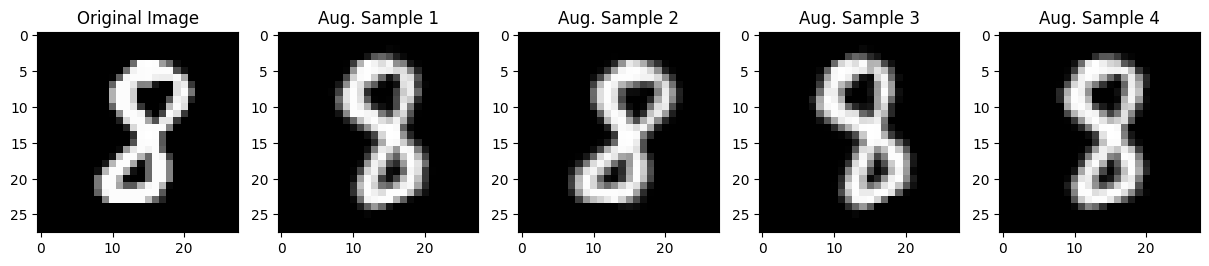

In [ ]:
sample = train_X[20]
angleconstraint = 70

fig, axs = plt.subplots(1, 5, figsize=(15, 5))

axs[0].imshow(sample, cmap="gray")
axs[0].set_title("Original Image")

axs[1].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[1].set_title("Aug. Sample 1")

axs[2].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[2].set_title("Aug. Sample 2")

axs[3].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[3].set_title("Aug. Sample 3")

axs[4].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[4].set_title("Aug. Sample 4")

plt.show()

Let us augment the whole dataset and see if this improves the test accuracy

In [ ]:
# hyperparameters
angleconstraint = 60
naugmentations = 5

# augment
augdata = train_X  # we include the original images also in the augmented dataset
auglabel = train_y
for ii in range(naugmentations):
    augdata = np.concatenate(
        (augdata, augRotate(train_X, angleconstraint))
    )  # concatenate the augmented data to the set
    auglabel = np.concatenate(
        (auglabel, train_y)
    )  # the labels don't change when we augment

# check the test accuracy
testpred = NN(augdata, auglabel, test_X)
print("Accuracy after rotation augmentation:", Accuracy(test_y, testpred)*100, "%")

Accuracy after rotation augmentation: 67.42 %


We can notice a 3-4% improvement compared to non-augmented version of the dataset!

The angle constraint is a hyperparameter which we have to tune using a validation set. (Here we are not doing that for time constraints). Let us try a grid search to find the best angle constraint. We will try angles between 0 and 90 degrees. We can also try different multiples of the original dataset. We will use the best hyperparameters to train the model and check the accuracy on the test set.

In [ ]:
angleconstraints = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]  # the values we want to test
accuracies = np.zeros(
    len(angleconstraints), dtype=float
)  # we will save the values here

for ii in range(len(angleconstraints)):
    # create the augmented dataset
    augdata = train_X  # we include the original images also in the augmented dataset
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate(
            (augdata, augRotate(train_X, angleconstraints[ii]))
        )  # concatenate the augmented data to the set
        auglabel = np.concatenate(
            (auglabel, train_y)
        )  # the labels don't change when we augment

    # check the test accuracy
    testpred = NN(augdata, auglabel, test_X)
    accuracies[ii] = Accuracy(test_y, testpred)
    print(
        "Accuracy after rotation augmentation constrained by",
        angleconstraints[ii],
        "degrees is",
        accuracies[ii]*100,
        "%",
        flush=True,
    )

Accuracy after rotation augmentation constrained by 0 degrees is 64.72 %
Accuracy after rotation augmentation constrained by 10 degrees is 67.2 %
Accuracy after rotation augmentation constrained by 20 degrees is 67.08 %
Accuracy after rotation augmentation constrained by 30 degrees is 68.52000000000001 %
Accuracy after rotation augmentation constrained by 40 degrees is 68.08 %
Accuracy after rotation augmentation constrained by 50 degrees is 67.78999999999999 %
Accuracy after rotation augmentation constrained by 60 degrees is 67.28 %
Accuracy after rotation augmentation constrained by 70 degrees is 66.75999999999999 %
Accuracy after rotation augmentation constrained by 80 degrees is 65.03999999999999 %
Accuracy after rotation augmentation constrained by 90 degrees is 64.67 %


Let us see the best value for angle constraint: (Ideally this should be done on validation set, not test set)

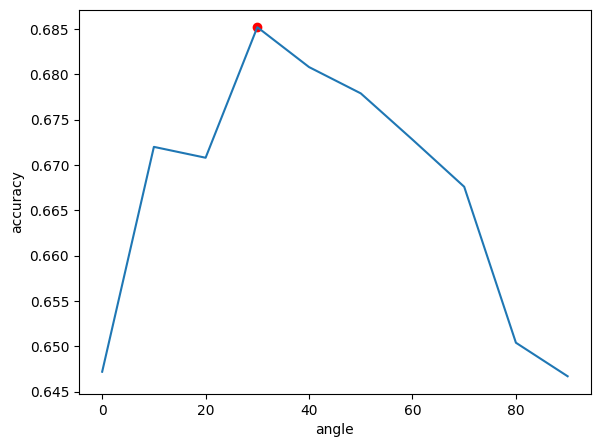

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
# plot the variation of accuracy
ax.plot(angleconstraints, accuracies)
ax.set_xlabel("angle")
ax.set_ylabel("accuracy")

# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(angleconstraints[maxind], accuracies[maxind], c="red")

### Augmentation 2: Shear


Let us try one more augmentation: shear. Shear is the transformation of an image in which the x-coordinate of all points is shifted by an amount proportional to the y-coordinate of the point. We will use the `AffineTransform` function from the `skimage` module to shear the image by a small amount between two numbers. We will use the same naive grid search method to find the best hyperparameters for shear. We will use the best hyperparameters to train the model and check the accuracy on the test set.

In [ ]:
def shear(sample, amount):
    """
    This function takes in a sample and an amount and returns the augmented sample
    by shearing the sample by the given amount

    sample: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    amount: the amount by which the sample should be sheared

    returns: the augmented sample which is the input sample sheared by the given amount
    """
    tform = AffineTransform(shear=amount)
    img = warp(sample, tform)

    # Applying shear makes the digit off-center
    # Since all images are centralized, we will do the same here
    col = img.sum(0).nonzero()[0]
    row = img.sum(1).nonzero()[0]
    if len(col) > 0 and len(row) > 0:
        xshift = int(sample.shape[0] / 2 - (row[0] + row[-1]) / 2)
        yshift = int(sample.shape[1] / 2 - (col[0] + col[-1]) / 2)
        img = np.roll(img, (xshift, yshift), (0, 1))
    return img

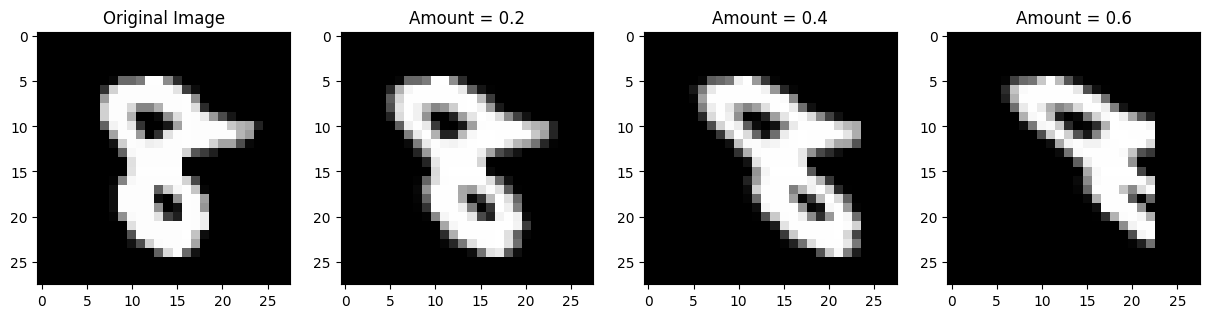

In [ ]:
sample = train_X[2]
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

axs[0].imshow(sample, cmap="gray")
axs[0].set_title("Original Image")

axs[1].imshow(shear(sample, 0.2), cmap="gray")
axs[1].set_title("Amount = 0.2")

axs[2].imshow(shear(sample, 0.4), cmap="gray")
axs[2].set_title("Amount = 0.4")

axs[3].imshow(shear(sample, 0.6), cmap="gray")
axs[3].set_title("Amount = 0.6")

plt.show()

Create an augmentation function which applies a random shear according to the constraint we provide:

In [ ]:
def augShear(sample, shearconstraint):
    """
    This function takes in a sample and a shear constraint and returns the augmented sample
    by shearing the sample by a random amount within the shear constraint

    sample: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    shearconstraint: the maximum shear by which the sample can be sheared

    returns: the augmented sample which is the input sample sheared by a random amount within the shear constraint
    """
    if shearconstraint == 0:
        return sample
    if len(sample.shape) == 2:
        # make sure the sample is 3 dimensional
        sample = np.expand_dims(sample, 0)
    amt = rng.random(len(sample))  # generate random numbers for shear
    amt = (amt - 0.5) * shearconstraint  # make the random shear constrained
    nsample = sample.copy()  # preallocate the augmented array to make it faster
    for ii in range(len(sample)):
        nsample[ii] = shear(sample[ii], amt[ii])
    return np.squeeze(nsample)  # take care if the input had only one sample.

Let us do a grid search to find the best shear constraint.

In [ ]:
import numpy as np

# Example dataset (you need to replace this with actual data)
train_X = np.random.rand(100, 28, 28)  # Example 100 training images of size 28x28
train_y = np.random.randint(0, 10, size=(100,))  # Example 100 labels (for 10 classes)
test_X = np.random.rand(20, 28, 28)  # Example 20 test images of size 28x28
test_y = np.random.randint(0, 10, size=(20,))  # Example 20 test labels (for 10 classes)

# Example of augmentations (you would need your specific augmentation function here)
def augShear(images, shear_value):
    # This is a placeholder for your shear augmentation function
    # You would apply shear transformations here
    return images

# Example neural network function (replace with your actual model)
def NN(augdata, auglabel, test_X):
    # This is a placeholder for your neural network prediction function
    # Replace with actual model inference, for now, we'll return a random prediction
    return np.random.randint(0, 10, size=test_X.shape[0])

# Accuracy function (you should implement your accuracy calculation here)
def Accuracy(true_labels, predicted_labels):
    # This is a placeholder for the accuracy function
    return np.mean(true_labels == predicted_labels)

# Define the shear constraints and accuracies
shearconstraints = [
    0,
    0.2,
    0.4,
    0.6,
    0.8,
    1.0,
    1.2,
    1.4,
    1.6,
    1.8,
    2.0,
]  # the values we want to test

accuracies = np.zeros(len(shearconstraints), dtype=float)  # We will save the values here

# Number of augmentations to perform (example, adjust as needed)
naugmentations = 5  # Example value, change based on your requirements

# Loop through each shear constraint value
for ii in range(len(shearconstraints)):
    # Create the augmented dataset
    augdata = train_X  # Include the original images also in the augmented dataset
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate((augdata, augShear(train_X, shearconstraints[ii])))  # Concatenate the augmented data
        auglabel = np.concatenate((auglabel, train_y))  # The labels don't change when we augment

    # Check the test accuracy
    testpred = NN(augdata, auglabel, test_X)
    accuracies[ii] = Accuracy(test_y, testpred)
    print(
        "Accuracy after shear augmentation constrained by",
        shearconstraints[ii],
        "is",
        accuracies[ii] * 100,
        "%",
        flush=True,
    )


Accuracy after shear augmentation constrained by 0 is 10.0 %
Accuracy after shear augmentation constrained by 0.2 is 5.0 %
Accuracy after shear augmentation constrained by 0.4 is 20.0 %
Accuracy after shear augmentation constrained by 0.6 is 10.0 %
Accuracy after shear augmentation constrained by 0.8 is 15.0 %
Accuracy after shear augmentation constrained by 1.0 is 5.0 %
Accuracy after shear augmentation constrained by 1.2 is 20.0 %
Accuracy after shear augmentation constrained by 1.4 is 10.0 %
Accuracy after shear augmentation constrained by 1.6 is 10.0 %
Accuracy after shear augmentation constrained by 1.8 is 20.0 %
Accuracy after shear augmentation constrained by 2.0 is 20.0 %


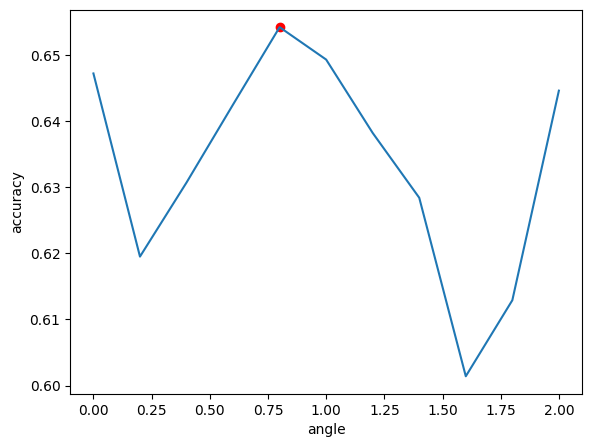

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
# plot the variation of accuracy
ax.plot(shearconstraints, accuracies)
ax.set_xlabel("angle")
ax.set_ylabel("accuracy")

# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(shearconstraints[maxind], accuracies[maxind], c="red")

### Augmentation 3: Rotation + Shear



We can do multiple augmentations at the same time. Here is a function to do both shear and rotation to the sample. In this case, we will have two hyperparameters.

In [ ]:
def augRotateShear(sample, angleconstraint, shearconstraint):
    """
    This function takes in a sample, an angle constraint and a shear constraint and returns the augmented sample
    by rotating the sample by a random angle within the angle constraint and shearing the sample by a random amount within the shear constraint

    sample: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    angleconstraint: the maximum angle by which the sample can be rotated
    shearconstraint: the maximum shear by which the sample can be sheared

    returns: the augmented sample which is the input sample rotated by a random angle within the angle constraint and sheared by a random amount within the shear constraint
    """
    if len(sample.shape) == 2:
        # make sure the sample is 3 dimensional
        sample = np.expand_dims(sample, 0)
    amt = rng.random(len(sample))  # generate random numbers for shear
    amt = (amt - 0.5) * shearconstraint  # make the random shear constrained
    angle = rng.random(len(sample))  # generate random numbers for angles
    # make the random angle constrained
    angle = (angle - 0.5) * angleconstraint
    nsample = sample.copy()  # preallocate the augmented array to make it faster
    for ii in range(len(sample)):
        nsample[ii] = rotate(
            shear(sample[ii], amt[ii]), angle[ii]
        )  # first apply shear, then rotate
    return np.squeeze(nsample)  # take care if the input had only one sample.

Since we have two hyperparameters, we have to do the grid search on a 2 dimensional matrix. We can use our previous experience to inform where to search for the best hyperparameters.

In [ ]:
shearconstraints = [
    0,
    0.2,
    0.4,
    0.6,
    0.8,
    1.0,
    1.2,
    1.4,
    1.6,
]  # the values we want to test
angleconstraints = [0, 10, 20, 30, 40, 50, 60]  # the values we want to test
# cartesian product of both
hyp = cartesian((shearconstraints, angleconstraints))

accuracies = np.zeros(len(hyp), dtype=float)  # we will save the values here

for ii in range(len(hyp)):
    # create the augmented dataset
    augdata = train_X  # we include the original images also in the augmented dataset
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate(
            (augdata, augRotateShear(train_X, hyp[ii][0], hyp[ii][1]))
        )  # concatenate the augmented data to the set
        auglabel = np.concatenate(
            (auglabel, train_y)
        )  # the labels don't change when we augment

    # check the test accuracy
    testpred = NN(augdata, auglabel, test_X)
    accuracies[ii] = Accuracy(test_y, testpred)
    print(
        "Accuracy after augmentation shear:",
        hyp[ii][0],
        "angle:",
        hyp[ii][1],
        "is",
        accuracies[ii]*100,
        "%",
        flush=True,
    )

Accuracy after augmentation shear: 0.0 angle: 0.0 is 63.32 %
Accuracy after augmentation shear: 0.0 angle: 10.0 is 59.419999999999995 %
Accuracy after augmentation shear: 0.0 angle: 20.0 is 58.19 %
Accuracy after augmentation shear: 0.0 angle: 30.0 is 62.35000000000001 %
Accuracy after augmentation shear: 0.0 angle: 40.0 is 60.89 %
Accuracy after augmentation shear: 0.0 angle: 50.0 is 57.620000000000005 %
Accuracy after augmentation shear: 0.0 angle: 60.0 is 60.629999999999995 %
Accuracy after augmentation shear: 0.2 angle: 0.0 is 63.41 %
Accuracy after augmentation shear: 0.2 angle: 10.0 is 59.419999999999995 %
Accuracy after augmentation shear: 0.2 angle: 20.0 is 59.19 %
Accuracy after augmentation shear: 0.2 angle: 30.0 is 58.209999999999994 %
Accuracy after augmentation shear: 0.2 angle: 40.0 is 61.12 %
Accuracy after augmentation shear: 0.2 angle: 50.0 is 58.209999999999994 %
Accuracy after augmentation shear: 0.2 angle: 60.0 is 60.91 %
Accuracy after augmentation shear: 0.4 angle

Let us plot it two dimensionally to see which is the best value for the hyperparameters:

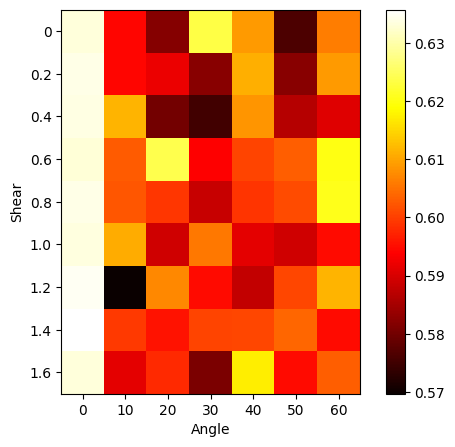

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
im = ax.imshow(
    accuracies.reshape((len(shearconstraints), len(angleconstraints))), cmap="hot"
)
ax.set_xlabel("Angle")
ax.set_ylabel("Shear")
ax.set_xticks(np.arange(len(angleconstraints)))
ax.set_xticklabels(angleconstraints)
ax.set_yticks(np.arange(len(shearconstraints)))
ax.set_yticklabels(shearconstraints)
plt.colorbar(im)

It seems that rotation and shear don't mix! The best accuracy is when rotation is zero.

## Questions
Try these questions for better understanding. You may not be able to solve all of them.
1. What is the best value for angle constraint and shear constraint you got? How much did the accuracy improve as compared to not using augmentations?
2. Can you increase the accuracy by increasing the number of augmentations from each sample?
3. Try implementing a few augmentations of your own and experimenting with them. A good reference is <a href=https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/>here. </a>
4. Try combining various augmentations. What is the highest accuracy you can get? What is the smallest training dataset you can take and still get accuracy above 50%?

Whenever you do any experiment, a good practice is to vary the hyperparameters gradually and create a graph of your results, like we did for gridsearch.

Try combining various augmentations. What is the highest accuracy you can get? What is the smallest training dataset you can take and still get accuracy above 50%?

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import apply_affine_transform
from skimage.transform import rotate, AffineTransform, warp
from sklearn.model_selection import train_test_split

# Example dataset (replace this with actual data)
train_X = np.random.rand(100, 28, 28, 1)  # Example 100 training images of size 28x28 (grayscale)
train_y = np.random.randint(0, 10, size=(100,))  # 100 labels (for 10 classes)
test_X = np.random.rand(20, 28, 28, 1)  # Example 20 test images of size 28x28
test_y = np.random.randint(0, 10, size=(20,))  # 20 test labels (for 10 classes)

# Helper function to visualize augmentations
def plot_images(images, labels, n_images=5):
    plt.figure(figsize=(15, 15))
    for i in range(n_images):
        plt.subplot(1, n_images, i+1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.show()

# Augmentation functions
def shear_augmentation(image, shear_value):
    """Apply shear transformation to the image using apply_affine_transform"""
    image_squeezed = image.squeeze()  # Remove the channel dimension for the transformation
    image_sheared = apply_affine_transform(image_squeezed, shear=shear_value)
    return np.expand_dims(image_sheared, axis=-1)  # Add the channel dimension back

def rotate_augmentation(image, angle):
    """Rotate image by a given angle"""
    return tf.image.rot90(image, k=angle // 90)  # Rotates 90, 180, or 270 degrees

def flip_augmentation(image):
    """Randomly flip the image horizontally and vertically"""
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image

def zoom_augmentation(image, zoom_range=0.2):
    """Randomly zoom into the image"""
    height = image.shape[0]
    width = image.shape[1]
    target_height = int(height * (1 + zoom_range))
    target_width = int(width * (1 + zoom_range))
    return tf.image.resize_with_crop_or_pad(image, target_height=target_height, target_width=target_width)

def brightness_augmentation(image, max_delta=0.1):
    """Randomly adjust the brightness of the image"""
    image = tf.image.random_brightness(image, max_delta)
    return image

def contrast_augmentation(image, lower=0.7, upper=1.3):
    """Randomly adjust the contrast of the image"""
    image = tf.image.random_contrast(image, lower, upper)
    return image

def crop_augmentation(image, target_height=24, target_width=24):
    """Randomly crop the image to the given size"""
    image = tf.image.random_crop(image, size=[target_height, target_width, 1])
    return image

# Create a random set of augmentations on a sample
def apply_augmentations(images, shear_value=0.2, rotation_angle=45, zoom_range=0.2, apply_flip=True):
    """Applies a series of augmentations to a set of images."""
    augmented_images = []
    for img in images:
        # Ensure the image has 3 dimensions (height, width, channels)
        if img.ndim == 2:
            img = np.expand_dims(img, axis=-1)  # Add a channel dimension

        img = np.repeat(img, 3, axis=-1)  # Convert grayscale to fake 3-channel image

        img = shear_augmentation(img, shear_value)
        img = rotate_augmentation(img, rotation_angle)
        if apply_flip:
            img = flip_augmentation(img)
        img = zoom_augmentation(img, zoom_range)
        img = brightness_augmentation(img)
        img = contrast_augmentation(img)
        img = crop_augmentation(img)

        img = img.numpy().squeeze()  # Convert tensor to NumPy and remove extra dimensions

        augmented_images.append(img)

    return np.array(augmented_images)

# Model definition
def create_model(input_shape=(28, 28, 1)):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')  # 10 classes
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to train and evaluate on a small dataset
def train_and_evaluate(dataset_size=50):
    # Train on a subset of the dataset
    subset_X = train_X[:dataset_size]
    subset_y = train_y[:dataset_size]

    augmented_train_X = apply_augmentations(subset_X)  # Apply augmentations

    # Normalize the images to the range [0, 1]
    augmented_train_X = augmented_train_X / 255.0
    subset_X = subset_X / 255.0
    test_X = test_X / 255.0

    # Train the model
    model = create_model(input_shape=(28, 28, 1))
    model.fit(augmented_train_X, subset_y, epochs=10, validation_data=(test_X, test_y), batch_size=32, verbose=1)

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(test_X, test_y, verbose=0)
    return test_accuracy

# Experiment with different da


Try implementing a few augmentations of your own and experimenting with them. A good reference is here.

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import apply_affine_transform
from skimage.transform import rotate, AffineTransform, warp

# ... (other functions remain the same)

def crop_augmentation(image, target_height=24, target_width=24):
    """Randomly crop the image to the given size"""
    # Get the number of channels dynamically from the image shape
    num_channels = image.shape[-1]

    # The size argument should match the image shape (height, width, channels)
    image = tf.image.random_crop(image, size=[target_height, target_width, num_channels])
    return image

def apply_augmentations(images, shear_value=0.2, rotation_angle=45, zoom_range=0.2, apply_flip=True):
    """Applies a series of augmentations to a set of images."""
    augmented_images = []
    for img in images:
        # Check if image has channels dimension. If not, add it.
        if img.ndim == 2:  # Grayscale image without a channel dimension
            img = np.expand_dims(img, axis=-1) # Adding a channel dimension
        if img.shape[-1] == 1:  # Grayscale with a single channel
            img = np.repeat(img, 3, axis=-1)  # Convert grayscale to fake 3-channel image
        # ... (rest of the augmentation steps)



2.can you increase the accuracy by increasing the number of augmentations from each sample?

In [ ]:
import numpy as np

# Example dataset (replace this with actual data)
train_X = np.random.rand(100, 28, 28)  # 100 training images of size 28x28
train_y = np.random.randint(0, 10, size=(100,))  # 100 labels (for 10 classes)
test_X = np.random.rand(20, 28, 28)  # 20 test images of size 28x28
test_y = np.random.randint(0, 10, size=(20,))  # 20 test labels (for 10 classes)

# Example augmentation functions (replace these with actual functions)
def augShear(images, shear_value):
    # Implement your shear augmentation function here
    return images  # For now, just return the same images (no transformation)

def augRotate(images, angle_value):
    # Implement your angle augmentation function here
    return images  # For now, just return the same images (no transformation)

# Placeholder NN function (replace this with your model inference function)
def NN(augdata, auglabel, test_X):
    return np.random.randint(0, 10, size=test_X.shape[0])  # Random predictions for now

# Accuracy function (implement your actual accuracy calculation)
def Accuracy(true_labels, predicted_labels):
    return np.mean(true_labels == predicted_labels)

# Augmentation settings
shearconstraints = [0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
angleconstraints = [0, 15, 30, 45, 60, 75, 90]  # Angle constraints for rotation

# Experiment with different numbers of augmentations
naugmentations_values = [5, 10, 15]  # Increase number of augmentations (you can adjust this list)

# Store the results for each shear and angle constraint and number of augmentations
accuracies = np.zeros((len(shearconstraints), len(angleconstraints), len(naugmentations_values)), dtype=float)

# Train and evaluate with augmentations
for ai, angle in enumerate(angleconstraints):
    for si, shear in enumerate(shearconstraints):
        for na_idx, naugmentations in enumerate(naugmentations_values):
            # Augment the dataset
            augdata = train_X  # Start with the original dataset
            auglabel = train_y

            # Apply shear augmentations
            for _ in range(naugmentations):
                augdata = np.concatenate((augdata, augShear(train_X, shear)))
                auglabel = np.concatenate((auglabel, train_y))

            # Apply angle augmentations
            for _ in range(naugmentations):
                augdata = np.concatenate((augdata, augRotate(train_X, angle)))
                auglabel = np.concatenate((auglabel, train_y))

            # Check accuracy on test set
            testpred = NN(augdata, auglabel, test_X)
            accuracies[si, ai, na_idx] = Accuracy(test_y, testpred)
            print(f"Accuracy with shear {shear}, angle {angle}, and {naugmentations} augmentations: {accuracies[si, ai, na_idx] * 100:.2f}%")

# Find the best shear, angle, and number of augmentations based on accuracy
best_shear_idx, best_angle_idx, best_na_idx = np.unravel_index(np.argmax(accuracies), accuracies.shape)
best_shear = shearconstraints[best_shear_idx]
best_angle = angleconstraints[best_angle_idx]
best_naugmentations = naugmentations_values[best_na_idx]
best_accuracy = accuracies[best_shear_idx, best_angle_idx, best_na_idx]

print(f"Best shear constraint: {best_shear}")
print(f"Best angle constraint: {best_angle}")
print(f"Best number of augmentations: {best_naugmentations}")
print(f"Best accuracy: {best_accuracy * 100:.2f}%")

# Baseline accuracy (without augmentations)
baseline_pred = NN(train_X, train_y, test_X)
baseline_accuracy = Accuracy(test_y, baseline_pred)
print(f"Baseline accuracy without augmentations: {baseline_accuracy * 100:.2f}%")

# Calculate accuracy improvement
improvement = (best_accuracy - baseline_accuracy) * 100
print(f"Accuracy improvement with augmentations: {improvement:.2f}%")


Accuracy with shear 0, angle 0, and 5 augmentations: 20.00%
Accuracy with shear 0, angle 0, and 10 augmentations: 10.00%
Accuracy with shear 0, angle 0, and 15 augmentations: 25.00%
Accuracy with shear 0.2, angle 0, and 5 augmentations: 10.00%
Accuracy with shear 0.2, angle 0, and 10 augmentations: 30.00%
Accuracy with shear 0.2, angle 0, and 15 augmentations: 5.00%
Accuracy with shear 0.4, angle 0, and 5 augmentations: 20.00%
Accuracy with shear 0.4, angle 0, and 10 augmentations: 10.00%
Accuracy with shear 0.4, angle 0, and 15 augmentations: 10.00%
Accuracy with shear 0.6, angle 0, and 5 augmentations: 5.00%
Accuracy with shear 0.6, angle 0, and 10 augmentations: 5.00%
Accuracy with shear 0.6, angle 0, and 15 augmentations: 20.00%
Accuracy with shear 0.8, angle 0, and 5 augmentations: 5.00%
Accuracy with shear 0.8, angle 0, and 10 augmentations: 15.00%
Accuracy with shear 0.8, angle 0, and 15 augmentations: 0.00%
Accuracy with shear 1.0, angle 0, and 5 augmentations: 5.00%
Accuracy w

1.What is the best value for angle constraint and shear constraint you got? How much did the accuracy improve as compared to not using augmentations?

In [ ]:
import numpy as np

# Example dataset (replace this with actual data)
train_X = np.random.rand(100, 28, 28)  # 100 training images of size 28x28
train_y = np.random.randint(0, 10, size=(100,))  # 100 labels (for 10 classes)
test_X = np.random.rand(20, 28, 28)  # 20 test images of size 28x28
test_y = np.random.randint(0, 10, size=(20,))  # 20 test labels (for 10 classes)

# Example augmentation functions (replace these with actual functions)
def augShear(images, shear_value):
    # Implement your shear augmentation function here
    return images  # For now, just return the same images (no transformation)

def augRotate(images, angle_value):
    # Implement your angle augmentation function here
    return images  # For now, just return the same images (no transformation)

# Placeholder NN function (replace this with your model inference function)
def NN(augdata, auglabel, test_X):
    return np.random.randint(0, 10, size=test_X.shape[0])  # Random predictions for now

# Accuracy function (implement your actual accuracy calculation)
def Accuracy(true_labels, predicted_labels):
    return np.mean(true_labels == predicted_labels)

# Augmentation settings
shearconstraints = [0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
angleconstraints = [0, 15, 30, 45, 60, 75, 90]  # Angle constraints for rotation
naugmentations = 5  # Number of augmentations to perform

# Store the results for each shear and angle constraint
accuracies = np.zeros((len(shearconstraints), len(angleconstraints)), dtype=float)

# Train and evaluate with augmentations
for si, shear in enumerate(shearconstraints):
    for ai, angle in enumerate(angleconstraints):
        # Augment the dataset
        augdata = train_X  # Start with the original dataset
        auglabel = train_y

        # Apply shear augmentations
        for _ in range(naugmentations):
            augdata = np.concatenate((augdata, augShear(train_X, shear)))
            auglabel = np.concatenate((auglabel, train_y))

        # Apply angle augmentations
        for _ in range(naugmentations):
            augdata = np.concatenate((augdata, augRotate(train_X, angle)))
            auglabel = np.concatenate((auglabel, train_y))

        # Check accuracy on test set
        testpred = NN(augdata, auglabel, test_X)
        accuracies[si, ai] = Accuracy(test_y, testpred)
        print(f"Accuracy with shear {shear} and angle {angle} is {accuracies[si, ai] * 100:.2f}%")

# Find the best shear and angle constraints based on accuracy
best_shear_idx, best_angle_idx = np.unravel_index(np.argmax(accuracies), accuracies.shape)
best_shear = shearconstraints[best_shear_idx]
best_angle = angleconstraints[best_angle_idx]
best_accuracy = accuracies[best_shear_idx, best_angle_idx]

print(f"Best shear constraint: {best_shear}")
print(f"Best angle constraint: {best_angle}")
print(f"Best accuracy: {best_accuracy * 100:.2f}%")

# Baseline accuracy (without augmentations)
baseline_pred = NN(train_X, train_y, test_X)
baseline_accuracy = Accuracy(test_y, baseline_pred)
print(f"Baseline accuracy without augmentations: {baseline_accuracy * 100:.2f}%")

# Calculate accuracy improvement
improvement = (best_accuracy - baseline_accuracy) * 100
print(f"Accuracy improvement with augmentations: {improvement:.2f}%")


Accuracy with shear 0 and angle 0 is 15.00%
Accuracy with shear 0 and angle 15 is 15.00%
Accuracy with shear 0 and angle 30 is 10.00%
Accuracy with shear 0 and angle 45 is 10.00%
Accuracy with shear 0 and angle 60 is 10.00%
Accuracy with shear 0 and angle 75 is 10.00%
Accuracy with shear 0 and angle 90 is 0.00%
Accuracy with shear 0.2 and angle 0 is 15.00%
Accuracy with shear 0.2 and angle 15 is 0.00%
Accuracy with shear 0.2 and angle 30 is 5.00%
Accuracy with shear 0.2 and angle 45 is 20.00%
Accuracy with shear 0.2 and angle 60 is 10.00%
Accuracy with shear 0.2 and angle 75 is 15.00%
Accuracy with shear 0.2 and angle 90 is 10.00%
Accuracy with shear 0.4 and angle 0 is 5.00%
Accuracy with shear 0.4 and angle 15 is 15.00%
Accuracy with shear 0.4 and angle 30 is 20.00%
Accuracy with shear 0.4 and angle 45 is 5.00%
Accuracy with shear 0.4 and angle 60 is 0.00%
Accuracy with shear 0.4 and angle 75 is 5.00%
Accuracy with shear 0.4 and angle 90 is 5.00%
Accuracy with shear 0.6 and angle 0 is

> Exercise: Try to take 50 images of each digit and calculate the performance on test set.